<a href="https://colab.research.google.com/github/viswambhar-yasa/AuToDiFf/blob/main/Cantilever_beam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

!git clone https://github.com/viswambhar-yasa/AuToDiFf "/content/drive/My Drive/AutoDiff"

Mounted at /content/drive
fatal: destination path '/content/drive/My Drive/AutoDiff' already exists and is not an empty directory.


In [2]:
ls

drive/  sample_data/


In [3]:
import sys,os
sys.path.append('/content/drive/MyDrive/AutoDiff/')

In [5]:
cd /content/drive/MyDrive/AutoDiff/

/content/drive/MyDrive/AutoDiff


In [6]:
import autodiff as ad 
import numpy as np
from NN_architecture import NeuralNetLSTM,xavier,diff_n_times
import matplotlib.pyplot as plt 
from optimizers import *

In [7]:
def loss_calculator(model,points):
    """
    Calculates the loss within the domain nd boundary of the differential equation
    inputs:
    model: The Neural Network model to be trained
    points: The points at which loss should be calculated(should lie within the domain)
    returns:Mean Squared loss from all the points in domain [0,10]
    """
    X = ad.Variable(points,"X")
    
    val = (10-X)*(10-X)*model.output(X)
    #Force (S.I Units)
    p = 10000
    #Flexural Rigidity - EI
    F = 0.000005*200000*1000000
    temp = p/F

    f = (diff_n_times(val,X,2)) + ((temp*X))
    print(f.shape)
    lossd = ad.ReduceSumToShape(ad.Pow(f,2),())/100
    Xb = ad.Variable(np.array([[10]]))
    fb1 = model.output(Xb)
    lossb1 =  ad.ReduceSumToShape(ad.Pow(fb1,2),())
    fb2 = ad.grad(model.output(Xb),[Xb])[0]
    lossb2 =  ad.ReduceSumToShape(ad.Pow(fb2,2),())

    return lossd 


def sampler(n):
    """
    samples of random data points(uniformly distributed)
    inputs:
    n : number of data points

    returns array of size n  
    
    """
    np.random.seed(0)
    return np.reshape(np.random.uniform(0,10,n),(n,1))

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


#Instantiating model and optimizer
model = NeuralNetLSTM(10,1,1,1)
model.set_weights([xavier(i().shape[0],i().shape[1]) for i in model.get_weights()])
optimizer= Adamax(len(model.get_weights()))
epochs = 600
x=sampler(100)

In [8]:
loss_model=[]
#-------------------------------------------------------Training--------------------------------------------------
for i in range(epochs):
    with HiddenPrints():
      loss = loss_calculator(model,x)
      loss_model.append(loss)
      params = model.get_weights()
      grad_params = ad.grad(loss,params)
      new_params = optimizer([i() for i in params], [i() for i in grad_params])
      model.set_weights(new_params)
      loss2= loss_calculator(model,x)
    if (i%50)==0:
      print('iteration :',i," loss :",loss2())
    #Exit condition
    if loss2()< 1e-2:
        break


iteration : 0  loss : 2928.0107016367847
iteration : 50  loss : 220.76338996241125
iteration : 100  loss : 64.34281472963254
iteration : 150  loss : 25.067815898361445
iteration : 200  loss : 13.456053256476062
iteration : 250  loss : 8.476319659658463
iteration : 300  loss : 5.594581322896856
iteration : 350  loss : 3.6625555107235606
iteration : 400  loss : 2.1617597068289403
iteration : 450  loss : 1.0119252902647942
iteration : 500  loss : 0.3259669744959814
iteration : 550  loss : 0.07039514595737024


(100,)


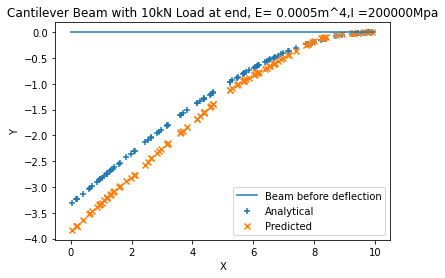

In [10]:
#-----------------------------------Plotting--------------------------------------
np.random.seed(0)
x_list = np.random.uniform(low=0,high=10,size=100)
def y(x,F,P):
    return ((-P*x**3)/(6*F)) + ((P*100*x)/(2*F)) - ((P*1000/(3*F)))
y_plot = y(x_list,0.000005*200000*1000000,10000)  
print(y_plot.shape)
y_list =[]
for i in x_list:
    X=ad.Variable(np.array([[i]]),name="X")
    val =(10-X)*(10-X)*model.output(X) 
    y_list.append(val()[0][0])
plt.plot(np.linspace(0,10,10),np.zeros(10),label="Beam before deflection")
plt.scatter(x_list,y_plot,marker="+",label="Analytical")
plt.scatter(x_list,y_list,marker="x",label="Predicted")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Cantilever Beam with 10kN Load at end, E= 0.0005m^4,I =200000Mpa")
plt.legend()
plt.show()